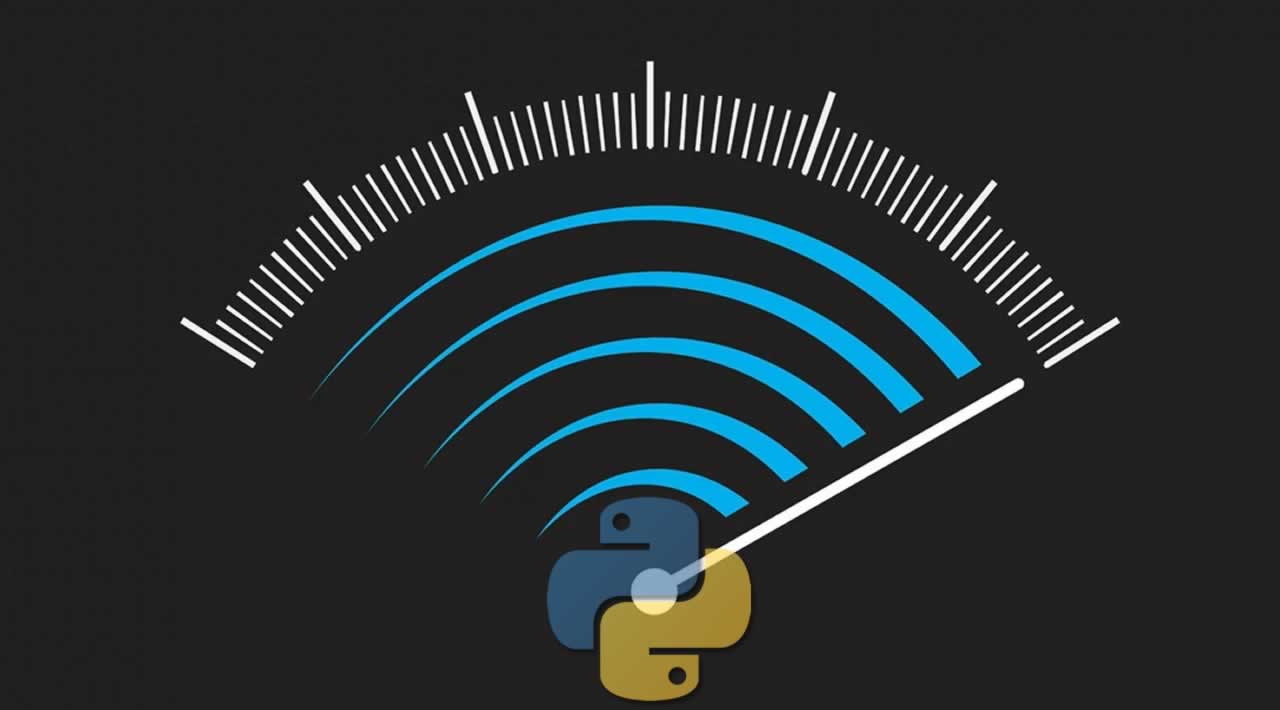

# Содержание

1. **Numba:** как писать код с for-циклами, за который не стыдно
    1. Краткое введение в `jit`-компиляцию: почему это работает. 
    2. `@numba.jit`. Директива `nopython`, её ограничения.
    3. Директива `parallel` и `numba.prange`: автоматическое распараллеливание кода.
    4. `@numba.vectorize` и `@numba.guvectorize`: автоматическая векторизация функций.
2. **joblib:** как распараллеливать код на `Python`
    1. `Parallel`, `delayed`: пишем свой `map-reduce`
    2. `Memory`: автоматическая мемоизация

# Введение

В науке, аналитике, машинном обучении код на `Python` преимущественно используют как "клей", позволяющий собрать воедино библиотеки, написанные на других языках программирования (часто C/C++, Fortran). Это определяет специфику разработки: вся вычислительная сложность переносится на библиотеки, к которым нужно правильно обращаться. В данном руководстве описаны техники оптимизации такого рода программ: распараллеливание вызовов функций и `for`-циклов (зачаствую в парадигме `map-reduce`), перенос вычислений на распределённый кластер или GPU, мемоизация. Также на примере рассматриваются многопоточные альтернативы популярных библиотек в духе `pandas`.

В первой части руководства рассматривается `numba` — `jit`-компилятор, переводящий функции на `Python` и `numpy` в байт-код. `numba` позволяет использовать в коде `for`-циклы, т.к. после компиляции они не приводят к падению производительности. Кроме того, декораторы `numba` позволяют легко распараллеливать вызовы функций и `for`-циклы, автоматически генерировать универсальные (в смысле `numpy`, т.е. принимающие на вход произвольный тензор) функции из обычных, а также переносить код на `GPU` в одну строчку кода. Преимущество `numba` в том, что его использование почти не требует усилий разработчика. Она идеально подходит для быстрого прототипирования, когда оптимизировать код вручную нерационально, а без этого он не отработает за разумное время. При этом `numba` нередко даёт результат сравнимый с оптимизацией того же кода вручную с переписыванием на чистом `numpy` векторизацией всех вычислений, распараллеливанием и т.д., что экономит время и силы программиста без потери качества. 

Во второй части руководства идёт речь  о `joblib` — библиотеке для максимально удобного написания `map-reduce` кода и мемоизации.

При написании руководства акцент был сделан на простоту в использовании и выразительность. Низкоуровневые детали происходящего, по возможности, опущены: заинтересованный читатель может ознакомиться с ними самостоятельно. Многие советы приобретают актуальность только при работе в многопроцессорной среде, но именно в таких условиях чаще всего происходит работа аналитика. Более продвинутые методы оптимизации — в духе `CPython`, — а также альтернативные  интерпретаторы — в духе `PyPy`, `Jython` и `Iron Python` — не рассмотрены сознательно, т.к. чаще всего не поддерживают основные библиотеки для `data science`.


# Numba: `jit`-компиляция


*При написании этого раздела были использованы материалы `Stan Seibert`, директора по инновациям в `Anaconda`.  
  С низкоуровневыми деталями реализации библиотеки можно ознакомиться в его [презентации](https://indico.cern.ch/event/709711/contributions/2915722/attachments/1638199/2614603/2018_04_23_Numba_DIANA_v2.pdf).*

[`numba`](http://numba.pydata.org/) это [`jit`-компилятор](https://en.wikipedia.org/wiki/Just-in-time_compilation) `Python`, т.е. динамический компилятор, который по запросу транслирует функции в байт-код, к которому потом обращаются последующие вызовы функции. Прирост производительности при этом обеспечивается за счёт того, что интерпретатору больше не нужно выполнять тело функции построчно, проверять, на что указывает каждое имя в коде и т.д. `Python` — динамически типизированный интерпретируемый язык, потому далеко не весь его функционал можно `jit`-компилировать, но то подмножество, которое используется для решения вычислительных задачи, чаще всего компилировать можно. 

Особенности `numba` можно резюмировать следующим списком:
* Работает со стандартным интерпретатором `Python`.
* Несмотря на то, что это компилятор, явным образом указывать типы ненужно: они выводятся автоматически.
* Тесная интеграция с `numpy`: поддерживается [почти весь функционал](http://numba.pydata.org/numba-doc/latest/reference/numpysupported.html).
* Не поддерживается `scipy`. В частности, это ограничивает использование `numba` в  статистике.
* Работает в многопоточной, многопроцессорной и распределённой среде, а также на `GPU`.
* Позволяет сочетать удобство программирования на `Python` с производительностью `C` и `Fortran`.

При этом `numba` не является:
* Заменой стандартного интерпретатора `Python` в отличие от `PyPy`, `Jython` и т.д.
* Транслятором кода на `Python` в `C/C++`

Функционал `numba` реализован в виде декораторов. Ниже рассмотрены основные из них

## `@numba.jit(nopython = True)`

`jit`-компиляция работает эффективнее всего, если функция, кроме вызова библиотек, использует только базовые конструкции языка в духе циклов и простейших элементов стандартной библиотеки. В противном случае `numba` генерирует код, который обращается к [`Python C API`](https://docs.python.org/2/c-api/index.html), чтобы обрабатывать все переменные как универсальные питоновские объекты — такой режим компиляции называется **объектным** (object mode). 

Декоратор `@numba.jit` по умолчанию сам решает, переходить ли в объектный режим или нет. Директива `nopython=True` заставляет его выбрасывать исключение, если перехода в объектный режим нельзя избежать. **Если не указать `nopython=True`, то прирост производительности гарантировать нельзя.**

Пользу от `numba` наглядно иллюстрирует пример вычисления **медианы средних Уолша**. 

Медиана средних Уолша -- мера центральной тенденции, которая по устойчивости к выбросам (*робастности*) находится между медианой и средним, а потому, с одной стороны, не слишком сильно меняется от наличия очень больших (по модулю) значений в данных (если их не больше примерно четверти от всей выборки), но, с другой стороны, не игнорирует хвосты распределения (т.к. большие по модулю значения могут быть осмысленными и важными сигналами).


Она вычисляется по следующей формуле:

$$
    W(X) := \mathrm{med} \left\{ \frac{X_i + X_j}{2}\ \middle|\ 1 \leq i < j \leq n \right\}
$$

где $n$ это размер выборки $X$. Т.е. это медиана множества полусумм всех возможных пар элементов выборки (без повторений).

*Именно эта статистика используется в Яндексе.Еде для вычисления среднего чека ресторанов.*

Тем не менее, у медианы средних есть очевидный недостаток: она вычисляется за `O(n^2)`. На практике это означает, что уже на выборке в 10-100 тысяч элементов вы её так просто не посчитаете. Кроме того, её довольно трудно векторизовать (вы скоро в этом убедитесь). Именно поэтому без оптимизаций не обойтись. Вряд ли конкретно медиана средних когда-нибудь будет bottleneck-ом вашего проекта, но в качестве учебного примера она очень поучительна.

---

Для того, чтобы вы прочувствовали мощь JIT-компиляции, **вам предлагается реализовать медиану средних Уолша** самостоятельно прямо на занятии. Затем мы JIT-компилируем вашу реализацию и сравним её с честной векторизованной реализацией на чистом `numpy`. Как по читаемости, так и по производительности, она будет, как минимум, не хуже.

1. **Наивная реализация на чистом Python**

In [ ]:
import numba
import numpy as np


def walsh_median_pure_python(sample: np.ndarray) -> float:
    # ВАШ КОД
    # TODO: удалить перед занятием
    walsh_averages = []
    n = len(sample)
    for i in range(n):
        for j in range(i + 1, n):
            walsh_averages.append((sample[i] + sample[j]) / 2)
    walsh_averages = sorted(walsh_averages)
    m = len(walsh_averages)
    if m % 2 == 0:
        return 0.5 * (walsh_averages[(m - 1) // 2] + walsh_averages[m // 2])
    return walsh_averages[m // 2]

2. **Тот же код, но с декоратором `@numba.jit`**

In [ ]:
@numba.jit(nopython=True)
def walsh_median_jit(sample):
    # Скопируйте свой код из предыдущей функции
    # TODO: Удалить перед занятием

    walsh_averages = []
    n = len(sample)
    for i in range(n):
        for j in range(i + 1, n):
            walsh_averages.append((sample[i] + sample[j]) / 2)
    walsh_averages = sorted(walsh_averages)
    m = len(walsh_averages)
    if m % 2 == 0:
        return 0.5 * (walsh_averages[(m - 1) // 2] + walsh_averages[m // 2])
    return walsh_averages[m // 2]

3. **Полностью векторизованная реализация на чистом `numpy`**

In [ ]:
def walsh_median_numpy(sample):
    # Есть в слайдах. Удалить содержимое перед занятием,
    # вставить по окончании упражнения.

    sample_vec = sample.reshape(-1, 1)
    pairwise_sums = (sample_vec + sample_vec.T) / 2
    indices = np.triu_indices_from(pairwise_sums) # https://vk.cc/8D03ZI
    pairwise_sums = np.asarray( pairwise_sums[indices] )
    return np.median(pairwise_sums)

А если вам не хватило того, как она выглядит, запустите её под `memory_profiler`-ом и подумайте, хотите ли вы таких спецэффектов в коде вашего проекта. :)

**Сравнение времени работы в каждом из трёх подходов**

In [ ]:
sample = np.random.rand(1000)

print("Pure Python:")
%timeit walsh_median_pure_python(sample)
print("@numba.jit(nopython=True):")
%timeit walsh_median_jit(sample)
print("Pure numpy")
%timeit walsh_median_numpy(sample)

Pure Python:
1 loop, best of 5: 734 ms per loop
@numba.jit(nopython=True):
The slowest run took 39.29 times longer than the fastest. This could mean that an intermediate result is being cached.
1 loop, best of 5: 94.1 ms per loop
Pure numpy
10 loops, best of 5: 21.8 ms per loop


Всего одна строчка кода даёт **почти десятикратный** прирост производительности по сравнению с чистым `Python`.  
Полностью векторизованная реализация на `numpy`, использующая нетривиальные конструкции, всего в два раза быстрее.  

## Директива `parallel` и `numba.prange`

В силу [особенностей языка](https://en.wikipedia.org/wiki/Global_interpreter_lock), программы на `Python` могут работать только в однопоточном режиме. Тем не менее, скомпилированный код можно выполнять на нескольких потоках, как в `C++`. Директива `parallel=True` указывает `numba` использовать все свободные ядра для вычислений.  

Кроме того, генератор `numba.prange` позволяет распараллеливать циклы. 
Вычислим таким образом медиану средних Уолша для набора выборок (считайте, для всех ресторанов Яндекс.Еды):

In [ ]:
def multiple_walsh_median_pure_python(samples: np.ndarray) -> np.ndarray:
    n_samples = samples.shape[0]
    walsh_medians = np.zeros(n_samples)
    for i in range(n_samples):
        walsh_medians[i] = walsh_median_jit(samples[i])
    return walsh_medians

Тот же код, но с `jit`-компиляцией и параллельным выполнением итераций цикла.

In [ ]:
@numba.jit(nopython=True, parallel=True)
def multiple_walsh_median_jit(samples: np.ndarray) -> np.ndarray:
    n_samples = samples.shape[0]
    walsh_medians = np.zeros(n_samples)
    for i in numba.prange(n_samples):
        walsh_medians[i] = walsh_median_jit(samples[i])
    return walsh_medians

Сравнение: 10000 выборок по 100 элементов.

In [ ]:
import multiprocessing as mp


print(f"Число ядер в системе: {mp.cpu_count()}")

Число ядер в системе: 2


In [ ]:
import scipy as sp
import scipy.stats as sps


n_samples = 10000
sample_size = 100
samples = sps.norm(loc=0.1, scale=1).rvs(size=(n_samples, sample_size))


%timeit -n 1 multiple_walsh_median_pure_python(samples)
%timeit -n 1 multiple_walsh_median_jit(samples)

1 loop, best of 5: 6.24 s per loop


/usr/local/lib/python3.7/dist-packages/numba/np/ufunc/parallel.py:363: NumbaWarning: The TBB threading layer requires TBB version 2019.5 or later i.e., TBB_INTERFACE_VERSION >= 11005. Found TBB_INTERFACE_VERSION = 9107. The TBB threading layer is disabled.
  warnings.warn(problem)


1 loop, best of 5: 4.11 s per loop


Вычисления медиан для разных выборок независимы, потому прирост скорости пропорционален количеству ядер на машине (а на профессиональном железе ядер может быть сколько угодно). На  Colab-инстансе ядер немного, но даже здесь виден почти двукратный прирост скорости работы.

**Обратите внимание!** `numba` не умеет автоматически рекурсивно JIT-компилировать все вызываемые функции. Вам придётся делать это вручную!

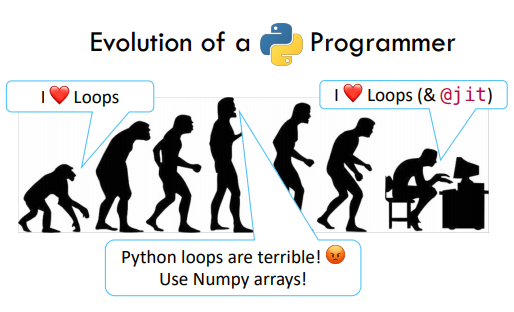

Компиляция функции может занимать продолжительное время. Чтобы это не происходило при каждом запуске программы, можно дополнительно указать директиву `cache=True`, которая сохранит закэширует код на диске. Это уместно, когда при запуске программы `jit`-компилируется не одна простая функция, а целая библиотека.

## `@numba.vectorize`

По функционалу этот декоратор аналогичен функции `numpy.vectorize`, но результат оказывается лучше, т.к. он скомпилирован, а обработка входных данных автоматически распараллеливается. `@numba.vectorize` можно применять только к функциям, которые принимают и возвращают скаляры. Разве что сигнатуру функции при этом нужно прописывать явно ([список поддерживаемых типов](https://numba.pydata.org/numba-doc/dev/reference/types.html)).


Его работу иллюстрирует параллельное вычисление плотности нормального распределения в `n` точках выборки.  
Такая задача возникает при обучении метода опорных векторов (`SVM`) на больших выборках при использовании радиального ядра 
$$K(x, x') := \exp\left( - \frac{\|x -x'\|}{2\sigma^2} \right)$$

In [ ]:
import math

@numba.vectorize("float64(float64, float64, float64)", 
                 nopython=True, target="parallel")
def normal_pdf_numba_vectorize(x, mu, sigma):
    normalizing_constant = 1 / (sigma * math.sqrt(2 * math.pi))
    power = (x - mu) ** 2 / (2 * sigma**2)
    return normalizing_constant * math.exp(power)

Для наглядности, векторизованный метод сравнивается с функцией `scipy.norm.pdf`.

In [ ]:
normal_rv = sps.norm()
sample_size = int(1e7)
sample = normal_rv.rvs(size=sample_size)

print("scipy.stats")
%timeit normal_rv.pdf(sample)
print("@numba.vectorize(nopython=True, target='parallel')")
%timeit normal_pdf_numba_vectorize(sample, 0, 1)

scipy.stats
1 loop, best of 5: 633 ms per loop
@numba.vectorize(nopython=True, target='parallel')
1 loop, best of 5: 327 ms per loop


Казалось бы, `scipy` — обкатанная в боях библиотека с множеством низкоуровневых оптимизаций.  
Тем не менее, `@numba.vectorize` работает быстрее за счёт распараллеливания обработки точек.

 ## Продвинутый материал: `@numba.guvectorize`
 
 `@numba.guvectorize` — обобщение `@numba.vectorize`, которое поддерживает вектор-функции векторного аргумента. Его синтаксис несколько контринтуитивен и напоминает `C`: функция обязательно должна возвращать `void`, возвращаемое значение при этом нужно записывать в отдельную переменную, которая подаётся на вход "по ссылке" последней в спике аргументов. 
 
 Такой дизайн продиктован поддержкой `CUDA`, т.е. необходимостью портирования кода на `GPU`. Написание нативного кода на `CUDA` — нетривиальная инженерная задача, потому проще смириться со странностями синтаксиса `numba`. 
 
 1. **Векторизованная версия `numpy`-версии медианы средних Уолша**

In [ ]:
def walsh_median_np_vectorize(samples):
    return np.vectorize(walsh_median_numpy, signature="(n)->()")(samples)

2. **Векторизация при помощи `@numba.guvectorize`**

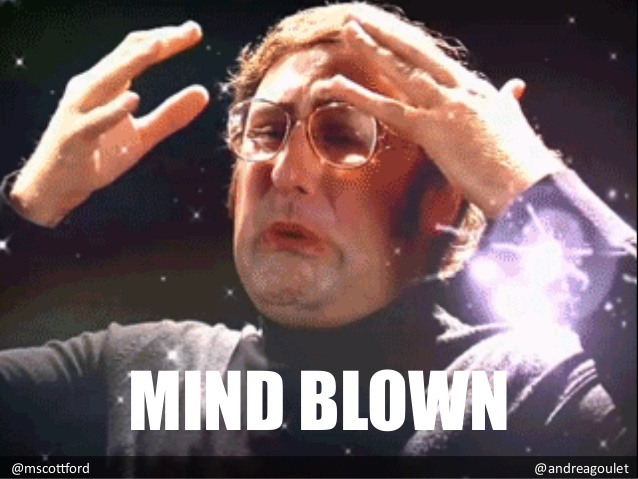

In [ ]:
@numba.guvectorize(
    ["void(float64[:], float64[:])"], # [:] указывает на массив
    "(n)->()", # сигнатура как в numpy.vectorize
    nopython=True, 
    target="parallel" # распараллеливает по нулевой размерности входа
)
def walsh_median_numba_vectorize(sample, result):
    walsh_averages = []
    n = len(sample)
    for i in range(n):
        for j in range(i + 1, n):
            walsh_averages.append((sample[i] + sample[j]) / 2)
    walsh_averages = sorted(walsh_averages)
    if n % 2 == 0:
        # [:] — особенность синтаксиса. Так нужно писать даже при том,
        # что в коде подразумевается, что result это число
        result[:] =  0.5 * (
            walsh_averages[(n - 1) // 2] + walsh_averages[n // 2]
        )
    else:
        result[:] = walsh_averages[n // 2]
    # функция не должна ничего возвращать, всё пишется в последний аргумент

Сравнение на 10000 выборок размера 100

In [ ]:
n_samples = 10000
sample_size = 100
samples = np.random.rand(n_samples, sample_size).astype(np.float32)

print("numpy.vectorize")
%timeit walsh_median_np_vectorize(samples)
results_buffer = np.zeros(samples.shape[0], dtype=np.float32)
print("@numba.guvectorize(..., nopython=True, target='parallel')")
%timeit walsh_median_numba_vectorize(samples, results_buffer)

numpy.vectorize
1 loop, best of 5: 2.71 s per loop
@numba.guvectorize(..., nopython=True, target='parallel')
1 loop, best of 5: 4.12 s per loop


Конкретно на Colab мало ядер, потому может показаться, что прироста производительности нет (более того, становится медленнее). Тем не менее, на машине с 64 ядрами тот же код даёт прирост производительности **более чем в 20 раз**.

# Joblib: распараллеливание и мемоизация 

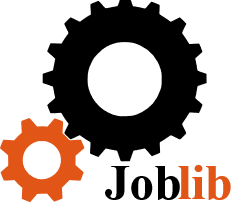

В тех случаях, когда использовать `numba` не получается, а распараллелить код нужно, можно воспользоваться пакетом `joblib`.  
`joblib` также поддерживает эффективную мемоизацию (кэширование результатов вычисления функции).

## `joblib.Parallel`, `joblib.delayed`

Распараллеливание кода с помощью `joblib` происходит за счёт вызова функций `Parallel` и `delayed`.  
`Parallel` создаёт пул процессов, а `delayed` позволяет передать ему функцию. `joblib` накладывает ограничение, что и аргументы функции, и её возвращаемое значение должны быть сериализуемы. Это необходимо для того, чтобы преобразовать функцию вместе с содержимым в набор байтов, который потом передаётся процессам-исполнителям. Чаще всего оно выполнено. Т.е. `joblib` может распараллелить не только всё то же, что и `numba`, но и многое другое.

Для иллюстрации использован пример векторизованной медианы средних Уолша, но в этот раз выборок мало, зато все они большого размера. Это принципиальный момент: создание процесса это тяжёлая операция, которая, по сути, создаёт копию текущего окружения. Если функция на каждом конкретном аргументе вычисляется быстро, то затраты на создание процессов и пересылку аргументов и возвращаемых значений между процессами перевесят выгоду от распараллеливания кода.

In [ ]:
import joblib

n_samples = 100
sample_size = 10000
samples = np.random.rand(n_samples, sample_size).astype(np.float32)

In [ ]:
%%time
print("joblib")
_ = joblib.Parallel(n_jobs=-1)( # использовать все доступные процессоры
        joblib.delayed(walsh_median_numpy)(sample) 
        for sample in samples
    );

joblib
CPU times: user 829 ms, sys: 93.4 ms, total: 923 ms
Wall time: 2min 1s


In [ ]:
%%time
print("numpy.vectorize")
walsh_median_np_vectorize(samples)

numpy.vectorize
CPU times: user 2min 46s, sys: 507 ms, total: 2min 46s
Wall time: 2min 46s


Параллельный запуск при помощи `joblib` отрабатывает примерно во столько же раз быстрее, сколько процессоров в системе.

## `joblib.Memory`

`joblib` предоставляет механизм для кэширования результатов вычисления функций.
Это очень удобно, когда запусков планируется мало, но каждый запуск занимает значительное время (скажем, несколько часов) и нет уверенности, что программа не упадёт с ошибкой, так и не досчитав.  

В такой ситуации было бы очень уместно сохранить результаты промежуточных вычислений, чтобы потом просто загрузить их из памяти и начать с того же места, на котором исполнение прервалось.

Эту логику реализует класс `joblib.Memory`. Достаточно только указать папку, в которой будут хранится результаты, а остальное — проверку аргументов на соответствие, сохранение и подгрузку результатов из кэша — он сделает сам.

In [ ]:
memory = joblib.Memory("~/.cache_dir", verbose=1)

Разницу можно проиллюстрировать на примере какой-нибудь медленной функции

In [ ]:
@memory.cache # достаточно просто написать декоратор
def walsh_median_numpy_cached(sample):
    return walsh_median_numpy(sample)

Первый запуск

In [ ]:
%%time
walsh_median_numpy_cached(samples[0])

________________________________________________________________________________
[Memory] Calling __main__--content-<ipython-input-815a3399e3c4>.walsh_median_numpy_cached...
walsh_median_numpy_cached(array([0.284237, ..., 0.075169], dtype=float32))
________________________________________walsh_median_numpy_cached - 1.7s, 0.0min
CPU times: user 1.65 s, sys: 5.99 ms, total: 1.65 s
Wall time: 1.67 s


0.4975769

Второй запуск с подгрузкой значения из кэша

In [ ]:
%%time
walsh_median_numpy_cached(samples[0])

CPU times: user 1.19 ms, sys: 0 ns, total: 1.19 ms
Wall time: 1.2 ms


0.4975769